<a href="https://colab.research.google.com/github/SLCFLAB/hd2025_time_series/blob/main/day1/Day1_Stationarity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 자기상관(Autocorrelation)과 백색잡음(White Noise)

이 파트에서는 시계열 분석의 핵심 개념인 자기상관과 백색잡음에 대해 학습하도록 하겠습니다.

### 주요 학습 내용
1. **White Noise(백색잡음)의 개념과 특성**
   - 평균 0, 일정한 분산을 가진 독립적인 확률변수들의 집합
   - 시간에 따라 자기상관이 없는 완전히 무작위적인 시계열

2. **자기상관함수(ACF: Autocorrelation Function)**
   - 시계열 데이터가 과거의 자기 자신과 얼마나 상관되어 있는지 측정
   - 시차(lag)에 따른 상관관계를 시각화

3. **편자기상관함수(PACF: Partial Autocorrelation Function)**
   - 중간 시차의 영향을 제거한 순수한 자기상관
   - AR 모형의 차수 결정에 유용

4. **AR(1) 프로세스**
   - 가장 단순한 자기회귀 모형: $y_t = \phi⋅y_{t-1}+\epsilon_t$
   - $\phi$ 값에 따른 자기상관 패턴 변화 관찰

5. **Ljung-Box 검정**
   - 통계적으로 white noise 여부를 검정
   - H0: 자기상관이 없다 (white noise)

6. **Random Walk vs White Noise**
   - Random Walk: white noise의 누적합
   - 비정상 시계열의 대표적인 예


## 실습 전 알아두기

### White Noise의 특징
- **평균**: $E[ \epsilon_t]=0$
- **분산**: $Var[\epsilon_t]=\sigma^2$
- **자기공분산**: $Cov[\epsilon_t, \epsilon_s] = 0 (t \neq s)$

### ACF 해석 방법
- **White Noise**: 모든 시차에서 자기상관이 거의 0
- **AR(1)**: 지수적으로 감소하는 패턴
- **Random Walk**: 천천히 감소하는 높은 자기상관 (비정상성)

## 1. 필요한 라이브러리 불러오기

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
import seaborn as sns

plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

# 그래프 스타일 설정
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 10)

# 재현성을 위한 시드 설정
np.random.seed(42)

## 2. White Noise 생성 및 시각화

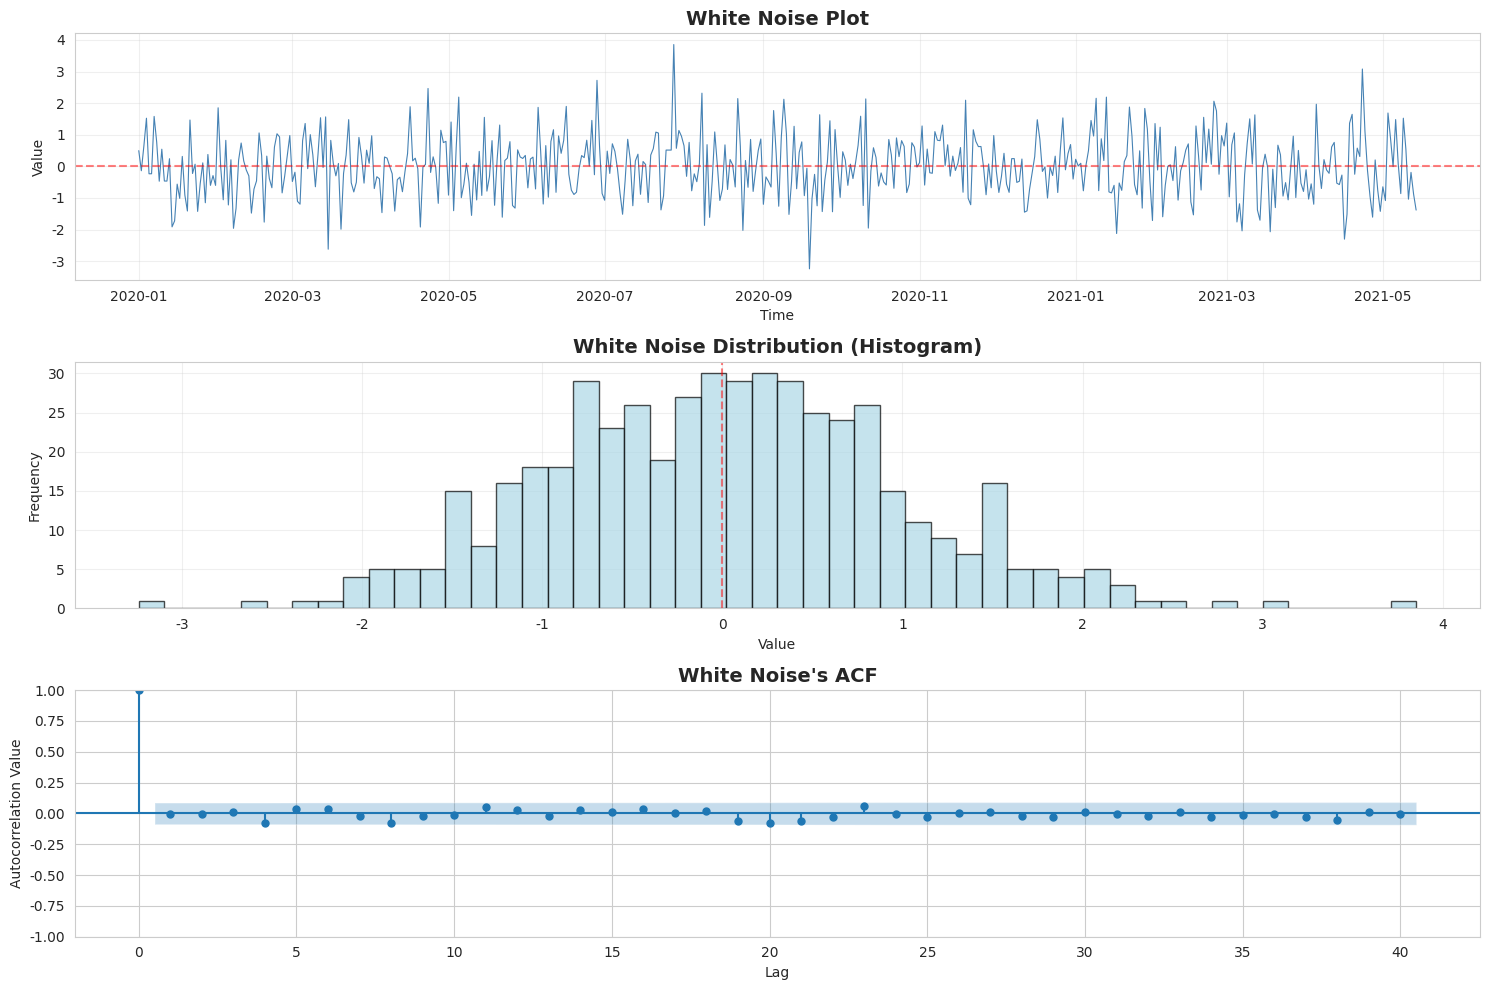


White Noise 기술통계량:
평균: 0.0068
표준편차: 0.9803
최솟값: -3.2413
최댓값: 3.8527


In [2]:
# White Noise 데이터 생성
# 평균 0, 표준편차 1인 정규분포에서 500개의 독립적인 관측값 생성
n_samples = 500
white_noise = np.random.normal(loc=0, scale=1, size=n_samples)

# 시계열 데이터프레임으로 변환
white_noise_series = pd.Series(white_noise, index=pd.date_range('2020-01-01', periods=n_samples, freq='D'))

# White Noise 시각화
fig, axes = plt.subplots(3, 1, figsize=(15, 10))

# 2-1. 시계열 플롯
axes[0].plot(white_noise_series, linewidth=0.8, color='steelblue')
axes[0].set_title('White Noise Plot', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Value')
axes[0].axhline(y=0, color='red', linestyle='--', alpha=0.5)
axes[0].grid(True, alpha=0.3)

# 2-2. 히스토그램 (분포 확인)
axes[1].hist(white_noise, bins=50, color='lightblue', edgecolor='black', alpha=0.7)
axes[1].set_title('White Noise Distribution (Histogram)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Value')
axes[1].set_ylabel('Frequency')
axes[1].axvline(x=0, color='red', linestyle='--', alpha=0.5)
axes[1].grid(True, alpha=0.3)

# 2-3. ACF (Autocorrelation Function) 플롯
plot_acf(white_noise_series, lags=40, ax=axes[2], alpha=0.05)
axes[2].set_title("White Noise's ACF", fontsize=14, fontweight='bold')
axes[2].set_xlabel('Lag')
axes[2].set_ylabel('Autocorrelation Value')

plt.tight_layout()
plt.savefig('white_noise_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# White Noise의 통계적 특성 출력
print(f"\nWhite Noise 기술통계량:")
print(f"평균: {np.mean(white_noise):.4f}")
print(f"표준편차: {np.std(white_noise):.4f}")
print(f"최솟값: {np.min(white_noise):.4f}")
print(f"최댓값: {np.max(white_noise):.4f}")

## White Noise 분석 결과

### 관찰된 특징
- **시계열 플롯**: 시간에 따라 무작위로 변동하며 특정 패턴이나 추세가 없음
- **히스토그램**: 평균 0 근처에서 정규분포를 따르는 형태
- **ACF 플롯**: 거의 모든 시차에서 신뢰구간 내에 존재 (자기상관 없음)

### 통계적 의미
White noise는 예측 불가능한 완전히 무작위적인 시계열입니다. 실제 데이터 분석에서 잔차(residual)가 white noise 형태를 따르면 모형이 데이터의 모든 패턴을 잘 포착했다는 의미입니다.

## 3. AR(1) 프로세스 생성 및 자기상관 분석

AR(1) 프로세스: $y_t = \phi \cdot y_{t-1} + \epsilon_t$    
$\phi$ (phi) 값을 다르게 하여 여러 AR(1) 프로세스 생성


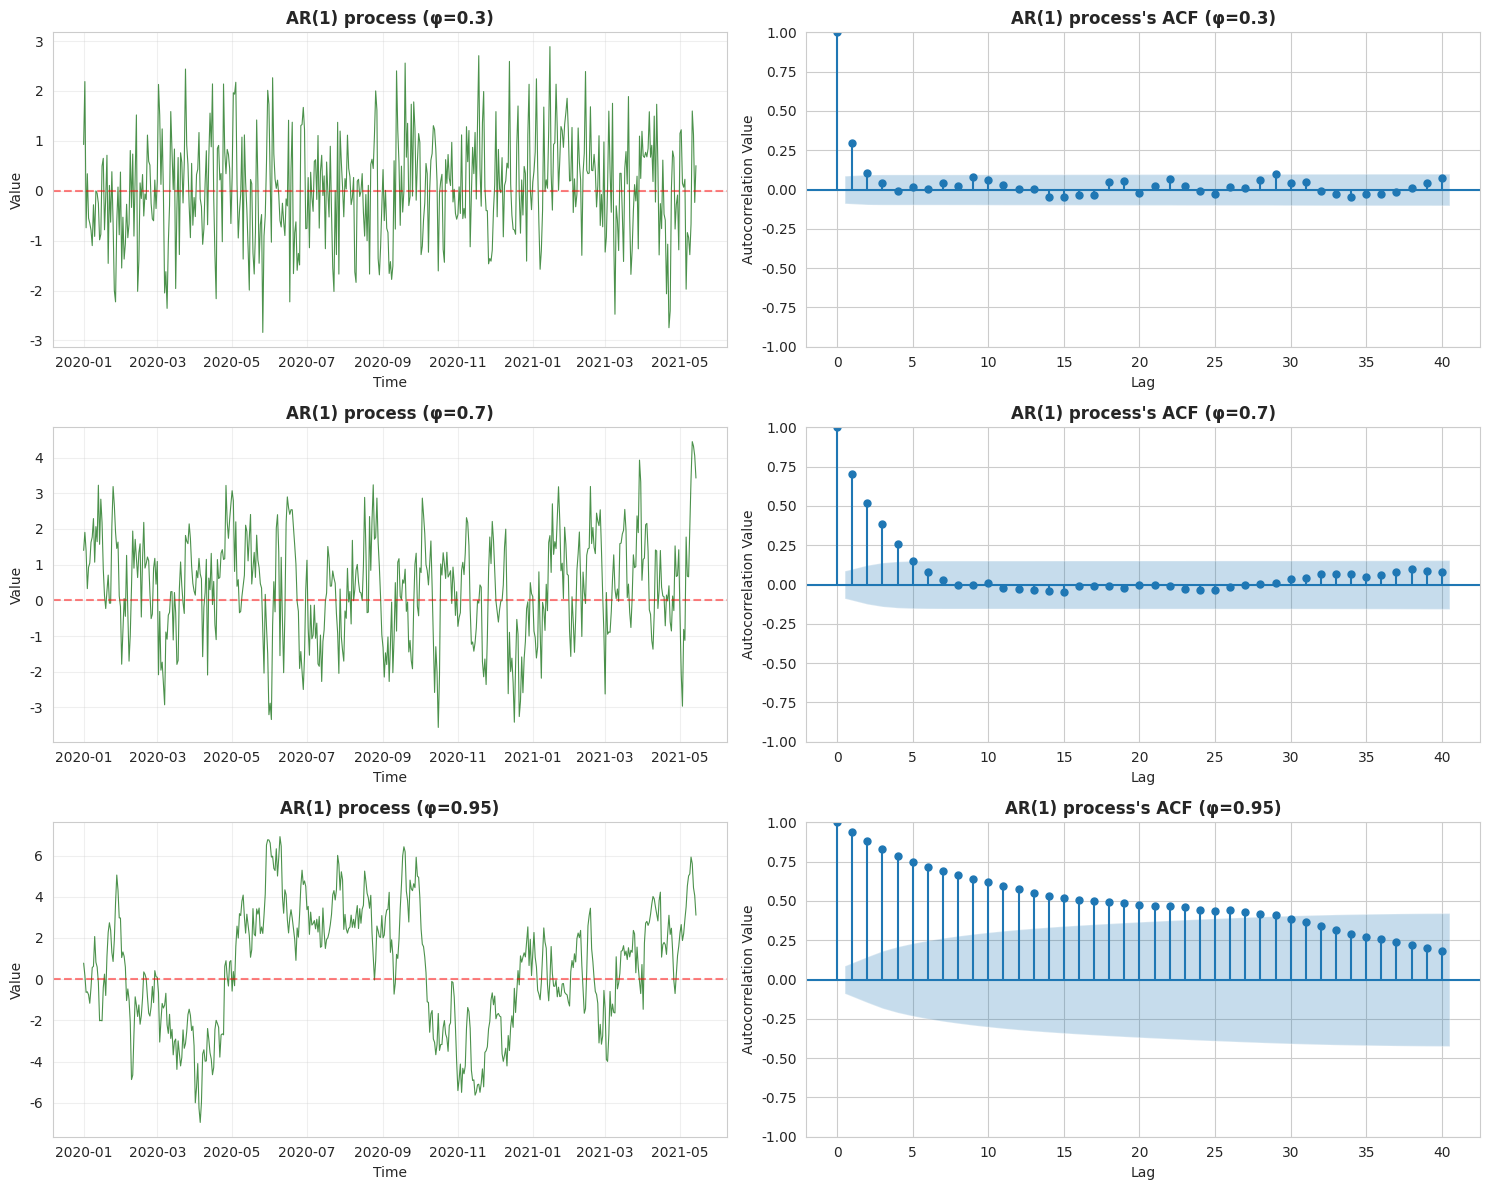

In [3]:
# 자기상관 계수
phi_values = [0.3, 0.7, 0.95]   # FIXME
ar_processes = {}

for phi in phi_values:
    # AR(1) 프로세스 생성
    ar_data = np.zeros(n_samples)
    ar_data[0] = np.random.normal(0, 1)  # 초기값

    for t in range(1, n_samples):
        # y_t = φ * y_{t-1} + ε_t
        ar_data[t] = phi * ar_data[t-1] + np.random.normal(0, 1)

    ar_processes[phi] = pd.Series(ar_data, index=pd.date_range('2020-01-01', periods=n_samples, freq='D'))

# AR(1) 프로세스 시각화
fig, axes = plt.subplots(len(phi_values), 2, figsize=(15, 12))

for idx, phi in enumerate(phi_values):
    # 시계열 플롯
    axes[idx, 0].plot(ar_processes[phi], linewidth=0.8, color='darkgreen', alpha=0.7)
    axes[idx, 0].set_title(f'AR(1) process (φ={phi})', fontsize=12, fontweight='bold')
    axes[idx, 0].set_xlabel('Time')
    axes[idx, 0].set_ylabel('Value')
    axes[idx, 0].axhline(y=0, color='red', linestyle='--', alpha=0.5)
    axes[idx, 0].grid(True, alpha=0.3)

    # ACF 플롯
    plot_acf(ar_processes[phi], lags=40, ax=axes[idx, 1], alpha=0.05)
    axes[idx, 1].set_title(f'AR(1) process\'s ACF (φ={phi})', fontsize=12, fontweight='bold')
    axes[idx, 1].set_xlabel('Lag')
    axes[idx, 1].set_ylabel('Autocorrelation Value')

plt.tight_layout()
plt.savefig('ar1_process_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

## AR(1) 프로세스의 자기상관 패턴

### $\phi$ 값에 따른 변화
- **φ = 0.3**: 약한 자기상관, ACF가 빠르게 0으로 수렴
- **φ = 0.7**: 중간 수준의 자기상관, 점진적으로 감소
- **φ = 0.95**: 강한 자기상관, 천천히 감소 (비정상성에 가까움)

### 이론적 배경
AR(1) 프로세스의 자기상관함수는 $\rho(k) = \phi^k$ 형태로 지수적으로 감소합니다. $\phi$가 1에 가까울수록 과거의 영향이 오래 지속됩니다.

## 4. PACF (Partial Autocorrelation Function) 분석

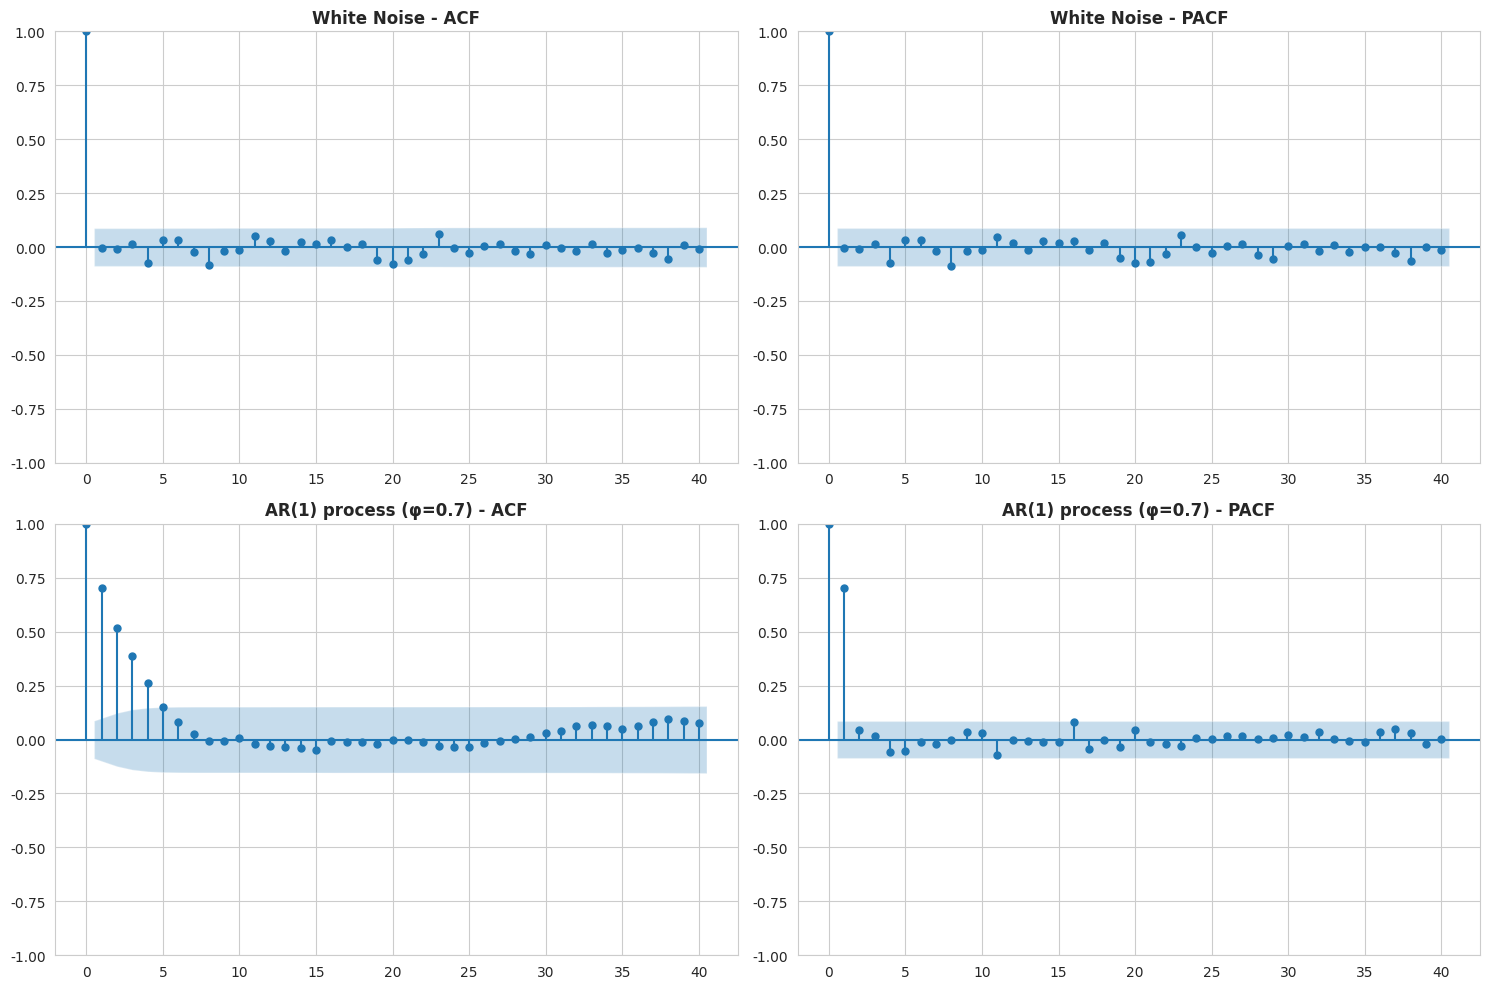

In [4]:
# White Noise와 AR(1) 프로세스의 ACF와 PACF 비교
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 4-1. White Noise의 ACF와 PACF
plot_acf(white_noise_series, lags=40, ax=axes[0, 0], alpha=0.05)
axes[0, 0].set_title('White Noise - ACF', fontsize=12, fontweight='bold')

plot_pacf(white_noise_series, lags=40, ax=axes[0, 1], alpha=0.05)
axes[0, 1].set_title('White Noise - PACF', fontsize=12, fontweight='bold')

# 4-2. AR(1) 프로세스 (φ=0.7)의 ACF와 PACF
plot_acf(ar_processes[0.7], lags=40, ax=axes[1, 0], alpha=0.05)
axes[1, 0].set_title('AR(1) process (φ=0.7) - ACF', fontsize=12, fontweight='bold')

plot_pacf(ar_processes[0.7], lags=40, ax=axes[1, 1], alpha=0.05)
axes[1, 1].set_title('AR(1) process (φ=0.7) - PACF', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('acf_pacf_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## ACF vs PACF 비교

### White Noise
- **ACF**: 모든 시차에서 통계적으로 유의하지 않음
- **PACF**: 모든 시차에서 통계적으로 유의하지 않음

### AR(1) 프로세스
- **ACF**: 지수적으로 감소하는 패턴 (무한히 이어짐)
- **PACF**: lag 1에서만 유의하고 나머지는 0 (AR 차수 식별에 유용)

### Key Insight
PACF가 lag p에서 절단되면 AR(p) 모형을 고려할 수 있습니다. 이는 ARIMA 모형 선택의 중요한 기준이 됩니다.

## 5. Ljung-Box 검정 (White Noise 검정)



Ljung-Box 검정 수행
* 귀무가설(H0): 데이터가 white noise이다 (자기상관이 없다)
* 대립가설(H1): 데이터가 white noise가 아니다 (자기상관이 있다)

In [5]:
print("\n[White Noise 데이터에 대한 Ljung-Box 검정]")
lb_test_wn = acorr_ljungbox(white_noise_series, lags=[10, 20, 30], return_df=True)
print(lb_test_wn)
print("\n해석: p-value > 0.05 이면 귀무가설을 기각하지 못함 (White Noise일 가능성 높음)")

print("\n[AR(1) 프로세스 (φ=0.7)에 대한 Ljung-Box 검정]")
lb_test_ar = acorr_ljungbox(ar_processes[0.7], lags=[10, 20, 30], return_df=True)
print(lb_test_ar)
print("\n해석: p-value < 0.05 이면 귀무가설을 기각 (White Noise가 아님, 자기상관 존재)")


[White Noise 데이터에 대한 Ljung-Box 검정]
      lb_stat  lb_pvalue
10   8.026137   0.626284
20  16.170505   0.705992
30  21.819399   0.860532

해석: p-value > 0.05 이면 귀무가설을 기각하지 못함 (White Noise일 가능성 높음)

[AR(1) 프로세스 (φ=0.7)에 대한 Ljung-Box 검정]
       lb_stat      lb_pvalue
10  510.736274  2.240331e-103
20  514.533775   2.627270e-96
30  516.986780   3.941963e-90

해석: p-value < 0.05 이면 귀무가설을 기각 (White Noise가 아님, 자기상관 존재)


## Ljung-Box 검정 결과 해석

### White Noise 검정 결과
- **p-value > 0.05**: 귀무가설을 기각할 수 없음
- **해석**: 자기상관이 통계적으로 유의하지 않음 → White Noise로 판단

### AR(1) 검정 결과
- **p-value < 0.05**: 귀무가설 기각
- **해석**: 자기상관이 통계적으로 유의함 → White Noise가 아님

### 적용 방법
시계열 모형을 구축한 후 잔차에 대해 Ljung-Box 검정을 수행합니다. 잔차가 white noise면 모형이 적절하다고 판단할 수 있습니다.


## 6. 실제 데이터와의 비교: Random Walk


Random Walk 생성 (white noise의 누적합): $y_t = y_{t-1} + \epsilon_t$

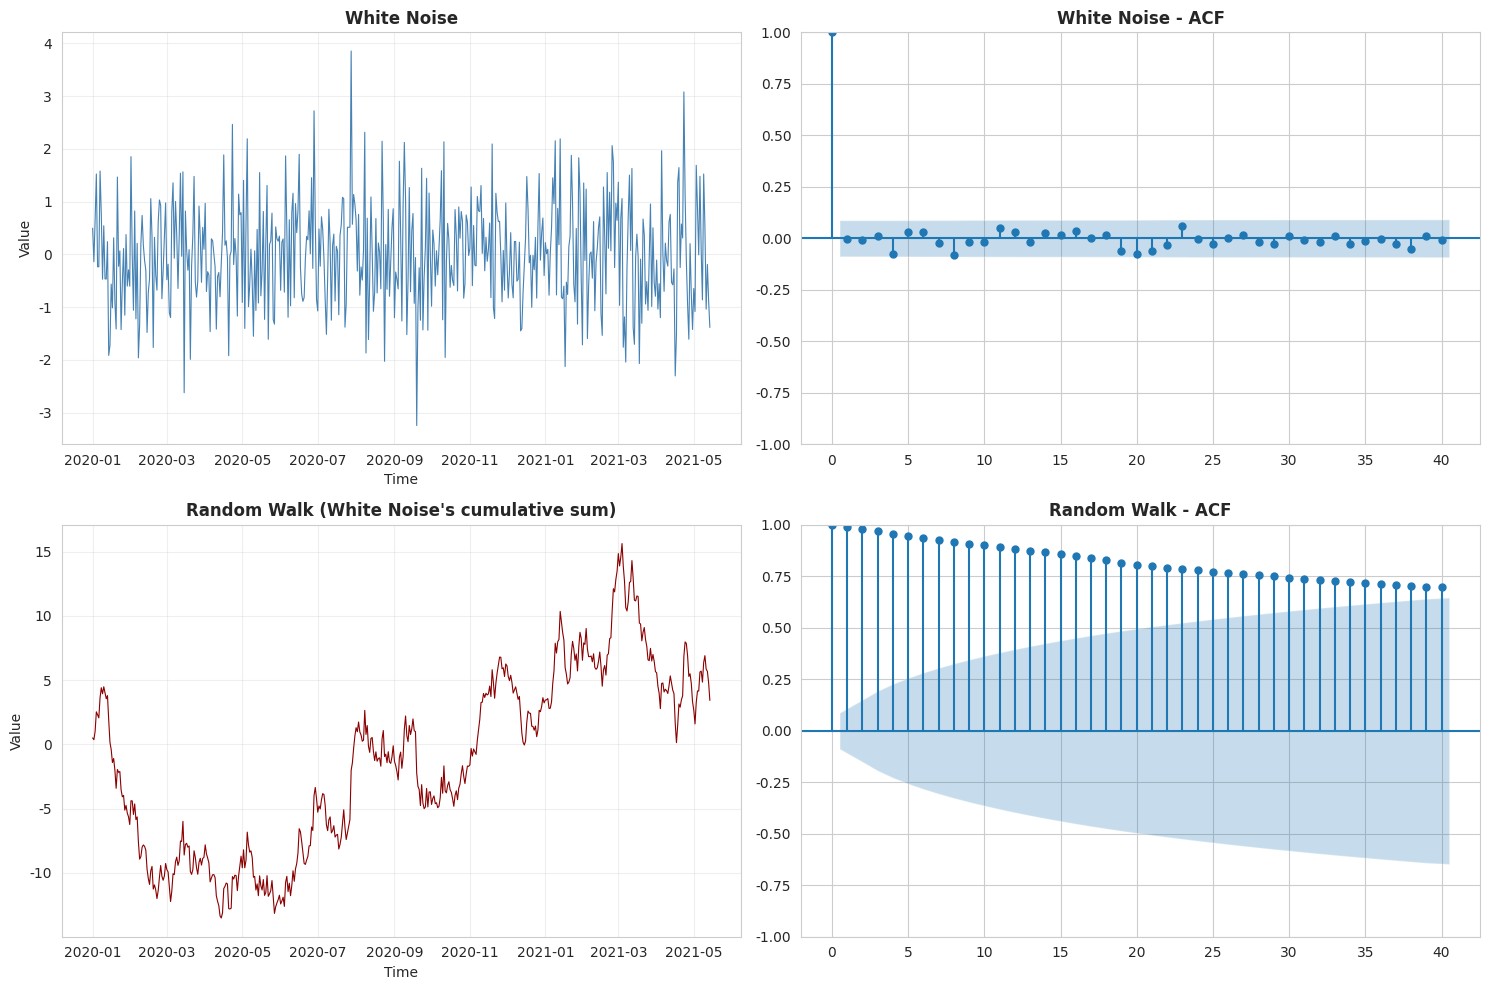

In [6]:
random_walk = np.cumsum(white_noise)  # White Noise의 누적합
random_walk_series = pd.Series(random_walk, index=pd.date_range('2020-01-01', periods=n_samples, freq='D'))

# Random Walk 시각화 및 ACF 비교
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 6-1. White Noise 시계열
axes[0, 0].plot(white_noise_series, linewidth=0.8, color='steelblue')
axes[0, 0].set_title('White Noise', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Time')
axes[0, 0].set_ylabel('Value')
axes[0, 0].grid(True, alpha=0.3)

# 6-2. White Noise ACF
plot_acf(white_noise_series, lags=40, ax=axes[0, 1], alpha=0.05)
axes[0, 1].set_title('White Noise - ACF', fontsize=12, fontweight='bold')

# 6-3. Random Walk 시계열
axes[1, 0].plot(random_walk_series, linewidth=0.8, color='darkred')
axes[1, 0].set_title('Random Walk (White Noise\'s cumulative sum)', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Time')
axes[1, 0].set_ylabel('Value')
axes[1, 0].grid(True, alpha=0.3)

# 6-4. Random Walk ACF
plot_acf(random_walk_series, lags=40, ax=axes[1, 1], alpha=0.05)
axes[1, 1].set_title('Random Walk - ACF', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('whitenoise_vs_randomwalk.png', dpi=300, bbox_inches='tight')
plt.show()

## Random Walk의 특성

### Random Walk vs White Noise
- **Random Walk**: white noise의 누적합
- **비정상성**: 분산이 시간에 따라 증가
- **높은 자기상관**: ACF가 천천히 감소하며 오랫동안 높은 값 유지

### 차분(Differencing)의 필요성
Random Walk를 1차 차분하면: $ \Delta y_t = y_t - y_{t-1} = \epsilon_t$ (white noise).    
즉, 비정상 시계열을 차분을 통해 정상 시계열로 변환할 수 있습니다.

# 실습: Analyzing Stationarity in Stock Market Data

Let's understand the concept of stationarity in financial time series. We will identify non-stationary patterns in stock prices. Then, apply transformations to achieve stationarity. Finally, perform statistical tests (ADF and KPSS) to validate stationarity.

This is the basic steps when you deal with market data before applying any fancy models.

In [7]:
from urllib.parse import urljoin
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy import stats

## 3.1. Load data

In [8]:
data_repo_url = "https://raw.githubusercontent.com/SLCFLAB/hd2025_time_series/refs/heads/main/datasets/"

In [9]:
assets = {
    'AAPL': 'aapl.csv',
    'NVDA': 'nvda.csv',
    'Bitcoin': 'bitcoin.csv',
    'Gold': 'gold.csv'
}

In [10]:
# 데이터 로드 함수
def load_asset_data(filepath, asset_name):
    """
    CSV 파일을 로드하고 전처리
    """
    file_url = urljoin(data_repo_url, filepath)
    df = pd.read_csv(file_url, index_col=0, parse_dates=True)

    # 컬럼명 정리 (소문자로 통일)
    df.columns = df.columns.str.lower()

    df['price'] = df['close']

    print(f"\n {asset_name} 데이터 로드 완료")
    print(f"   기간: {df.index[0].date()} ~ {df.index[-1].date()}")
    print(f"   데이터 포인트: {len(df)}개")
    print(f"   가격 범위: ${df['price'].min():.2f} ~ ${df['price'].max():.2f}")

    return df

In [11]:
# 모든 자산 데이터 로드
data = {}
for asset_name, filepath in assets.items():
    data[asset_name] = load_asset_data(filepath, asset_name)


 AAPL 데이터 로드 완료
   기간: 2015-10-06 ~ 2025-10-06
   데이터 포인트: 2515개
   가격 범위: $22.58 ~ $259.02

 NVDA 데이터 로드 완료
   기간: 2015-10-06 ~ 2025-10-06
   데이터 포인트: 2515개
   가격 범위: $0.63 ~ $188.89

 Bitcoin 데이터 로드 완료
   기간: 2015-10-06 ~ 2025-10-06
   데이터 포인트: 3654개
   가격 범위: $242.30 ~ $124772.94

 Gold 데이터 로드 완료
   기간: 2015-10-06 ~ 2025-10-06
   데이터 포인트: 2514개
   가격 범위: $1050.80 ~ $3969.70


## 3.2. Calculate Returns for All Assets

In [12]:
# 각 자산에 대해 수익률 계산
for asset_name, df in data.items():
    # 일간 수익률 (%)
    df['returns'] = df['price'].pct_change() * 100

    # 로그 수익률 (%)
    df['log_returns'] = np.log(df['price'] / df['price'].shift(1)) * 100

    # 1차 차분
    df['price_diff'] = df['price'].diff()

In [13]:
summary_stats = []

for asset_name, df in data.items():
    stats_dict = {
        'Asset': asset_name,
        'Mean Return (%)': df['returns'].mean(),
        'Std Dev (%)': df['returns'].std(),
        'Min Return (%)': df['returns'].min(),
        'Max Return (%)': df['returns'].max(),
        'Skewness': df['returns'].skew(),
        'Kurtosis': df['returns'].kurtosis()
    }
    summary_stats.append(stats_dict)

summary_df = pd.DataFrame(summary_stats)

In [14]:
summary_df

,Asset,Mean Return (%),Std Dev (%),Min Return (%),Max Return (%),Skewness,Kurtosis
0,AAPL,0.105561,1.838956,-12.864696,15.328853,0.153979,6.769120
1,NVDA,0.274560,3.141918,-18.755865,29.806699,0.543352,8.088228
2,Bitcoin,0.233761,3.542754,-37.169539,25.247169,-0.043607,7.766448
3,Gold,0.053912,0.947472,-4.978726,5.947668,-0.090225,3.577237


## 3.3 Visual Comparison Across Assets

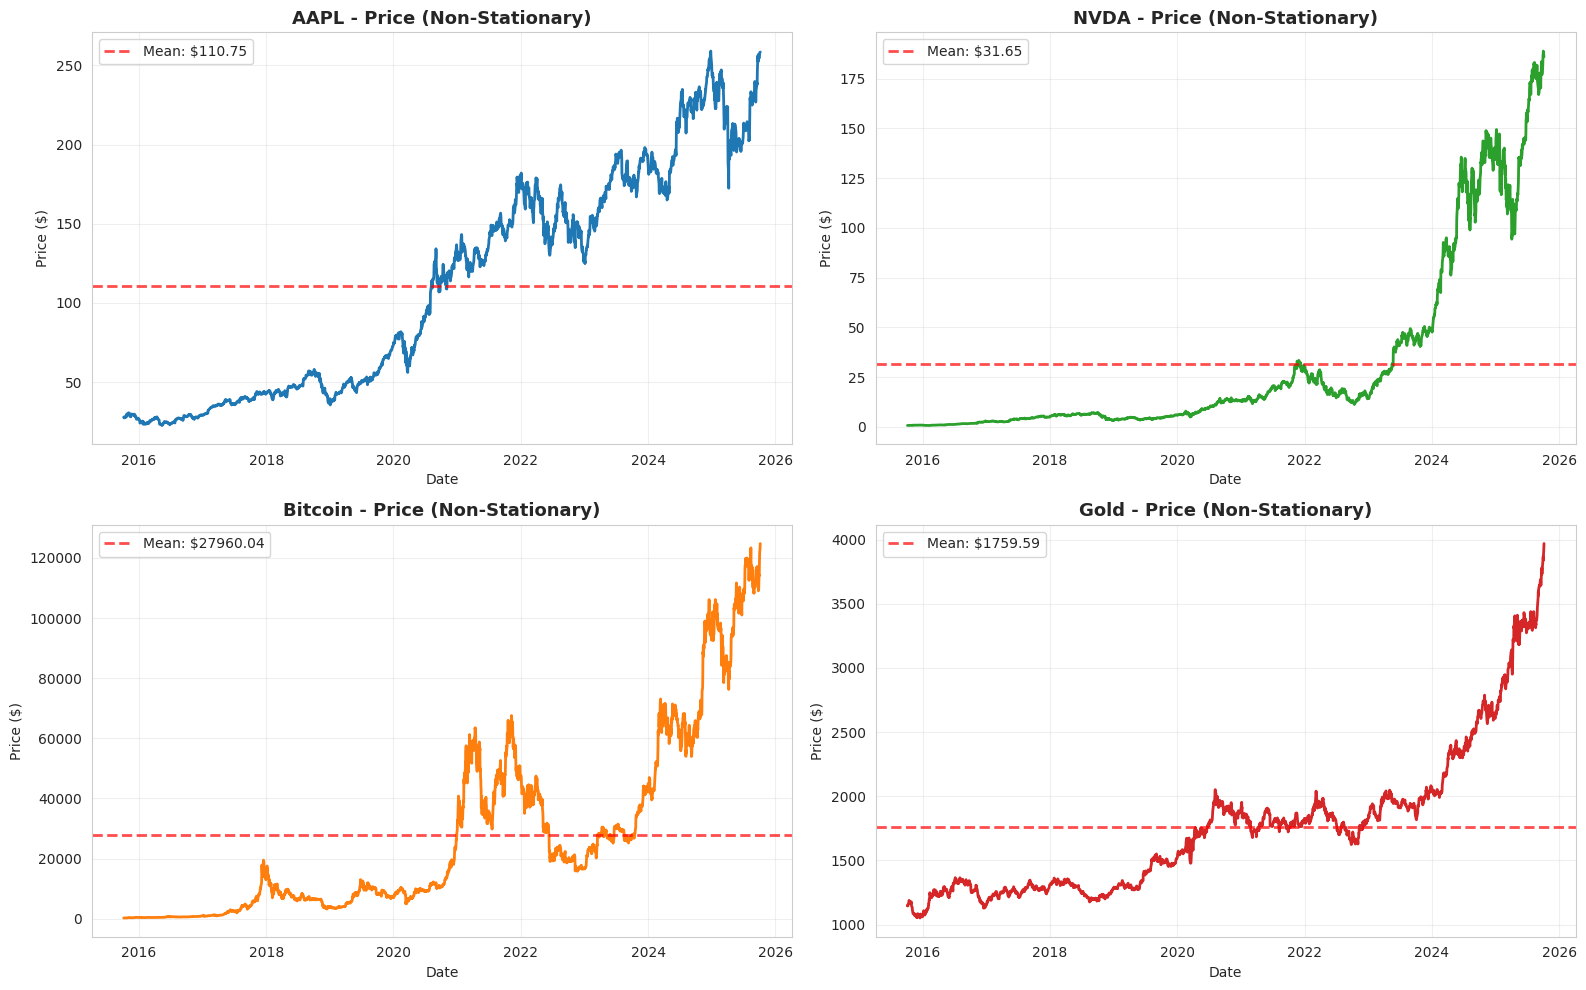

In [15]:
# 모든 자산의 가격 추이 비교
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.ravel()

colors = ['#1f77b4', '#2ca02c', '#ff7f0e', '#d62728']

for idx, (asset_name, df) in enumerate(data.items()):
    axes[idx].plot(df.index, df['price'], linewidth=2, color=colors[idx])
    axes[idx].set_title(f'{asset_name} - Price (Non-Stationary)',
                        fontsize=13, fontweight='bold')
    axes[idx].set_xlabel('Date')
    axes[idx].set_ylabel('Price ($)')
    axes[idx].grid(True, alpha=0.3)

    # 평균선 추가
    axes[idx].axhline(y=df['price'].mean(), color='red', linestyle='--',
                      linewidth=2, alpha=0.7, label=f"Mean: ${df['price'].mean():.2f}")
    axes[idx].legend()

plt.tight_layout()
plt.show()

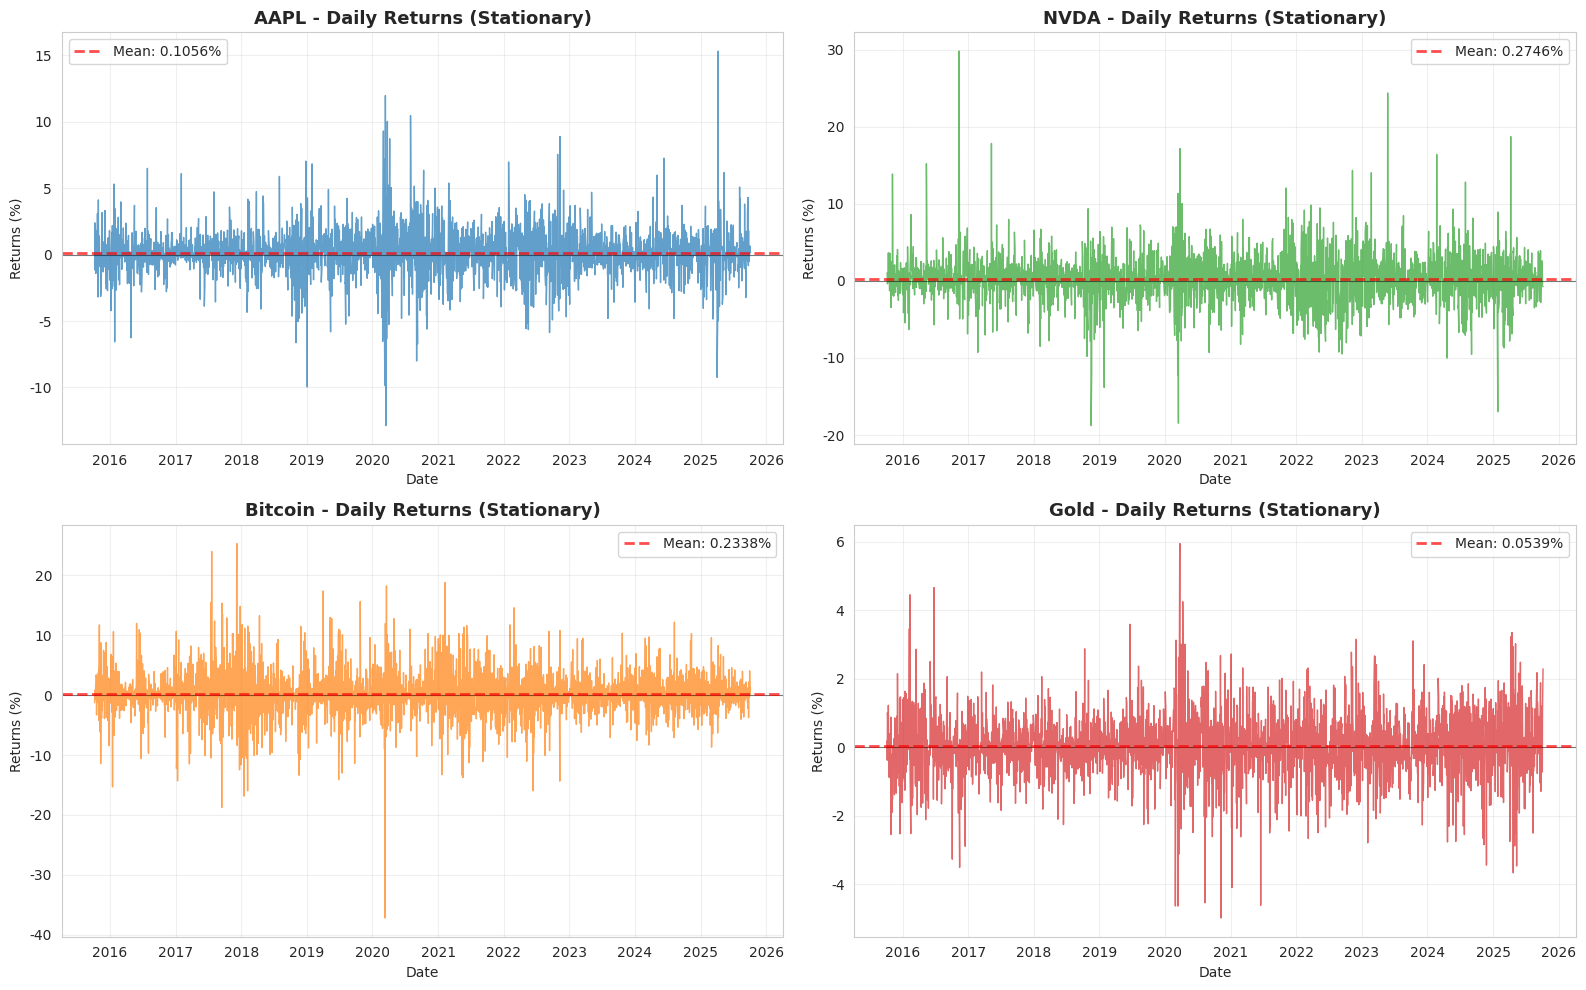

In [16]:
# 모든 자산의 수익률 추이 비교
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.ravel()

for idx, (asset_name, df) in enumerate(data.items()):
    axes[idx].plot(df.index, df['returns'], linewidth=1, color=colors[idx], alpha=0.7)
    axes[idx].set_title(f'{asset_name} - Daily Returns (Stationary)',
                        fontsize=13, fontweight='bold')
    axes[idx].set_xlabel('Date')
    axes[idx].set_ylabel('Returns (%)')
    axes[idx].axhline(y=0, color='black', linestyle='-', linewidth=0.8, alpha=0.5)
    axes[idx].axhline(y=df['returns'].mean(), color='red', linestyle='--',
                      linewidth=2, alpha=0.7, label=f"Mean: {df['returns'].mean():.4f}%")
    axes[idx].grid(True, alpha=0.3)
    axes[idx].legend()

plt.tight_layout()
plt.show()

## 3.4. Rolling Statistics Analysis

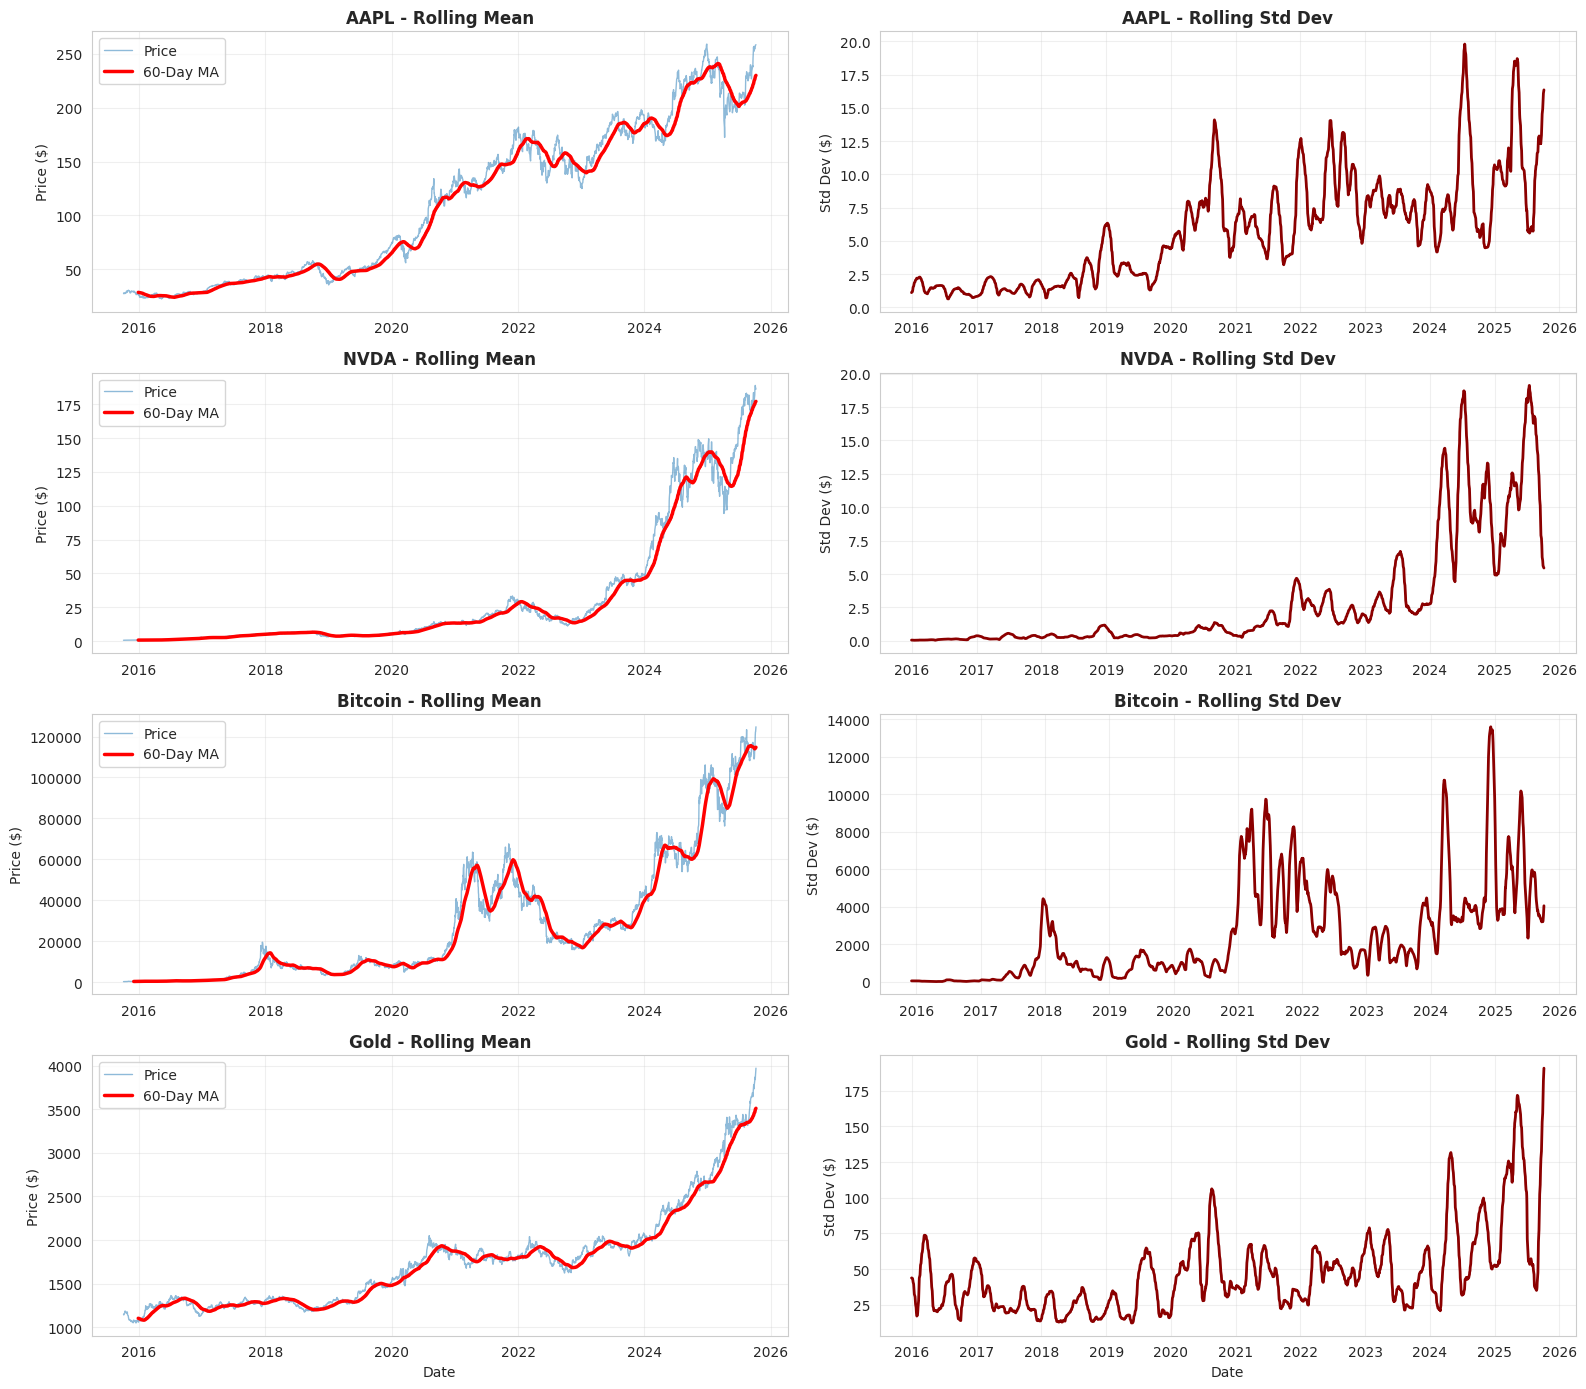

In [17]:
# 각 자산에 대해 이동 통계량 계산
window = 60  # 60일 이동 평균/표준편차

# 가격의 Rolling Statistics
fig, axes = plt.subplots(4, 2, figsize=(16, 14))

for idx, (asset_name, df) in enumerate(data.items()):
    # 이동 평균과 이동 표준편차 계산
    rolling_mean = df['price'].rolling(window=window).mean()
    rolling_std = df['price'].rolling(window=window).std()

    # 원본 데이터와 이동 평균
    axes[idx, 0].plot(df.index, df['price'], label='Price', alpha=0.5, linewidth=1)
    axes[idx, 0].plot(df.index, rolling_mean, label=f'{window}-Day MA',
                      linewidth=2.5, color='red')
    axes[idx, 0].set_title(f'{asset_name} - Rolling Mean', fontsize=12, fontweight='bold')
    axes[idx, 0].set_ylabel('Price ($)')
    axes[idx, 0].legend()
    axes[idx, 0].grid(True, alpha=0.3)

    # 이동 표준편차
    axes[idx, 1].plot(df.index, rolling_std, linewidth=2, color='darkred')
    axes[idx, 1].set_title(f'{asset_name} - Rolling Std Dev', fontsize=12, fontweight='bold')
    axes[idx, 1].set_ylabel('Std Dev ($)')
    axes[idx, 1].grid(True, alpha=0.3)

axes[-1, 0].set_xlabel('Date')
axes[-1, 1].set_xlabel('Date')

plt.tight_layout()
plt.show()

**모든 자산의 가격에서 평균과 분산이 시간에 따라 변화 → Non-stationary**

## 3.5. Distribution Analysis

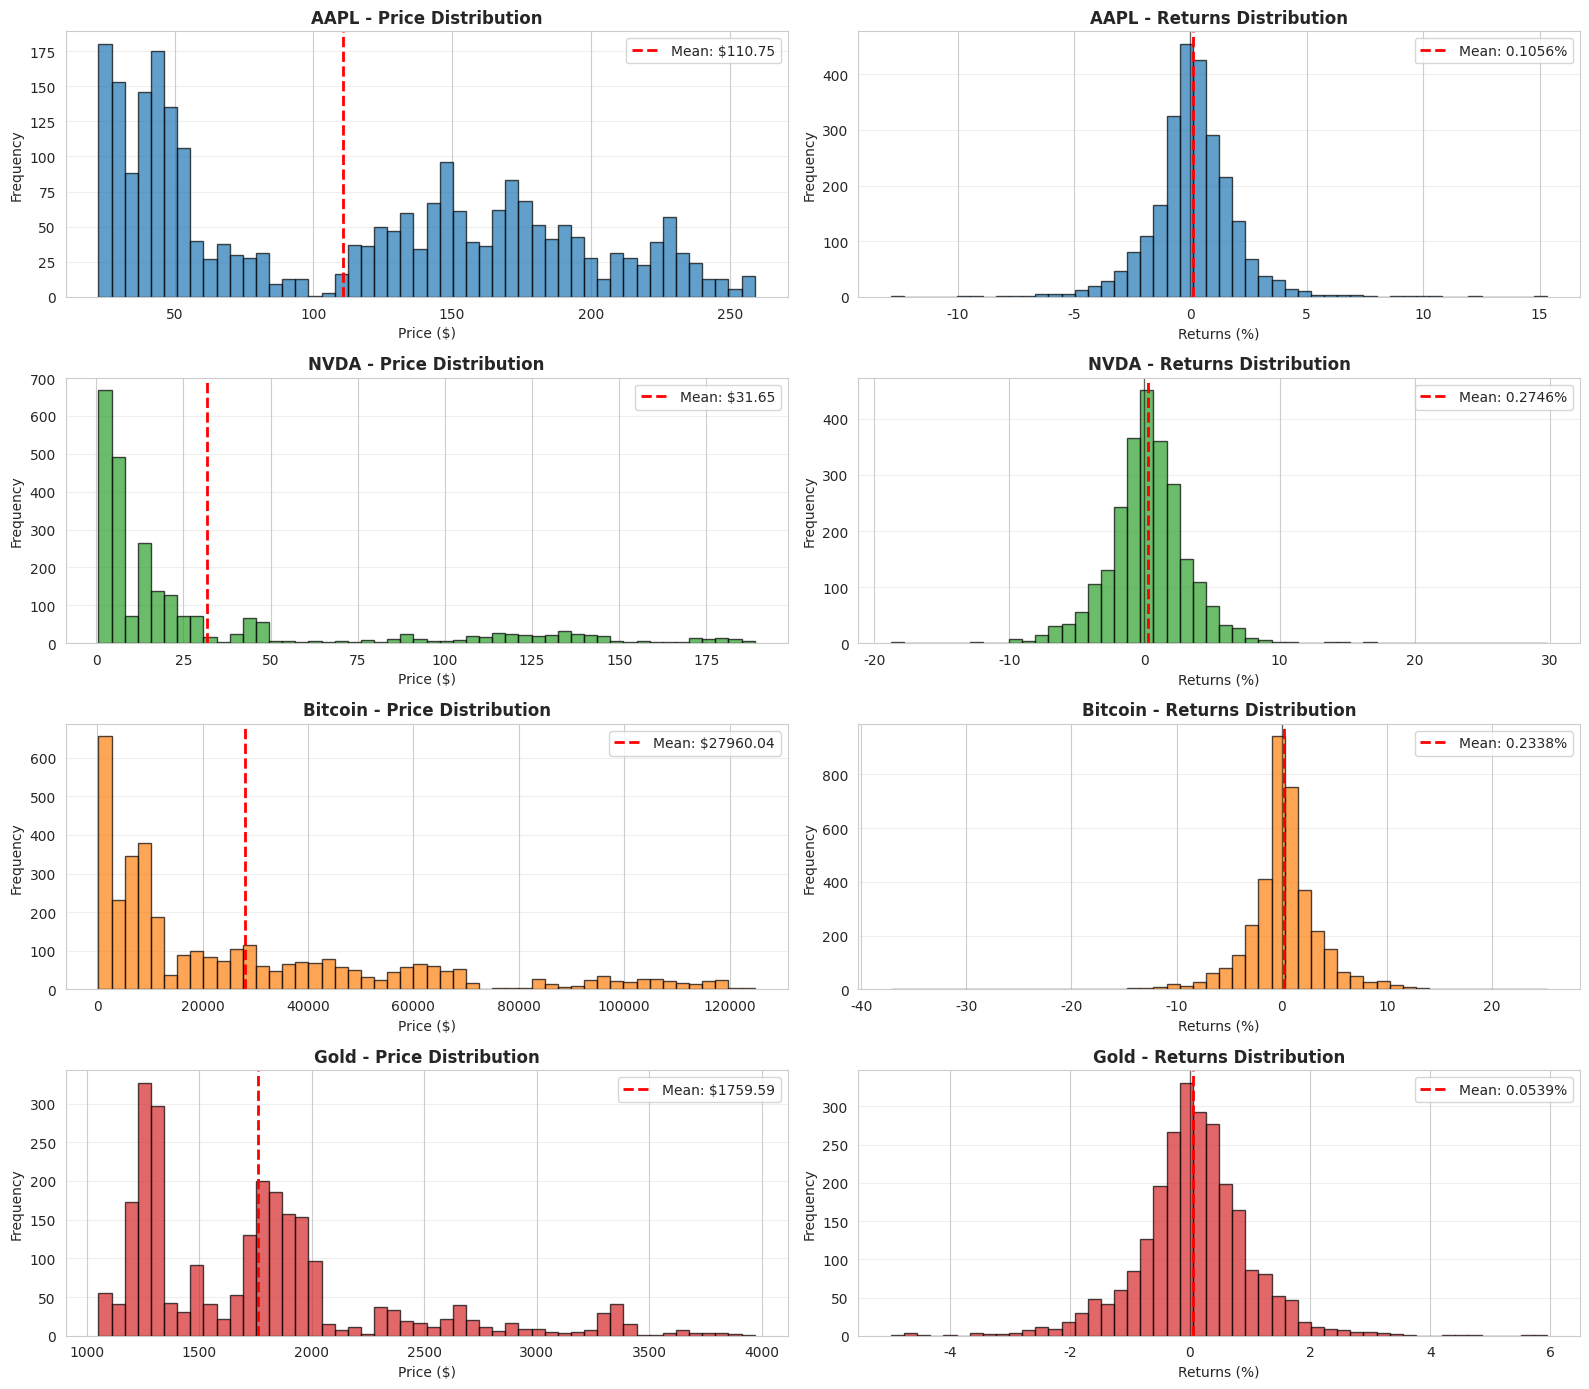

In [18]:
# 가격과 수익률의 분포 비교
fig, axes = plt.subplots(4, 2, figsize=(16, 14))

for idx, (asset_name, df) in enumerate(data.items()):
    # 가격 분포
    axes[idx, 0].hist(df['price'], bins=50, edgecolor='black',
                      alpha=0.7, color=colors[idx])
    axes[idx, 0].axvline(df['price'].mean(), color='red', linestyle='--',
                         linewidth=2, label=f"Mean: ${df['price'].mean():.2f}")
    axes[idx, 0].set_title(f'{asset_name} - Price Distribution',
                           fontsize=12, fontweight='bold')
    axes[idx, 0].set_xlabel('Price ($)')
    axes[idx, 0].set_ylabel('Frequency')
    axes[idx, 0].legend()
    axes[idx, 0].grid(True, alpha=0.3, axis='y')

    # 수익률 분포
    axes[idx, 1].hist(df['returns'].dropna(), bins=50, edgecolor='black',
                      alpha=0.7, color=colors[idx])
    axes[idx, 1].axvline(df['returns'].mean(), color='red', linestyle='--',
                         linewidth=2, label=f"Mean: {df['returns'].mean():.4f}%")
    axes[idx, 1].axvline(0, color='black', linestyle='-', linewidth=1, alpha=0.5)
    axes[idx, 1].set_title(f'{asset_name} - Returns Distribution',
                           fontsize=12, fontweight='bold')
    axes[idx, 1].set_xlabel('Returns (%)')
    axes[idx, 1].set_ylabel('Frequency')
    axes[idx, 1].legend()
    axes[idx, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

In [19]:
# 정규성 검정
print("\n=== Normality Test (D'Agostino-Pearson) ===\n")
for asset_name, df in data.items():
    _, p_value_returns = stats.normaltest(df['returns'].dropna())
    result = 'Normal' if p_value_returns >= 0.05 else 'Not Normal'
    print(f"{asset_name:10} Returns: p-value = {p_value_returns:.6f} → {result}")


=== Normality Test (D'Agostino-Pearson) ===

AAPL       Returns: p-value = 0.000000 → Not Normal
NVDA       Returns: p-value = 0.000000 → Not Normal
Bitcoin    Returns: p-value = 0.000000 → Not Normal
Gold       Returns: p-value = 0.000000 → Not Normal


## 3.6 Autocorrelation Analysis

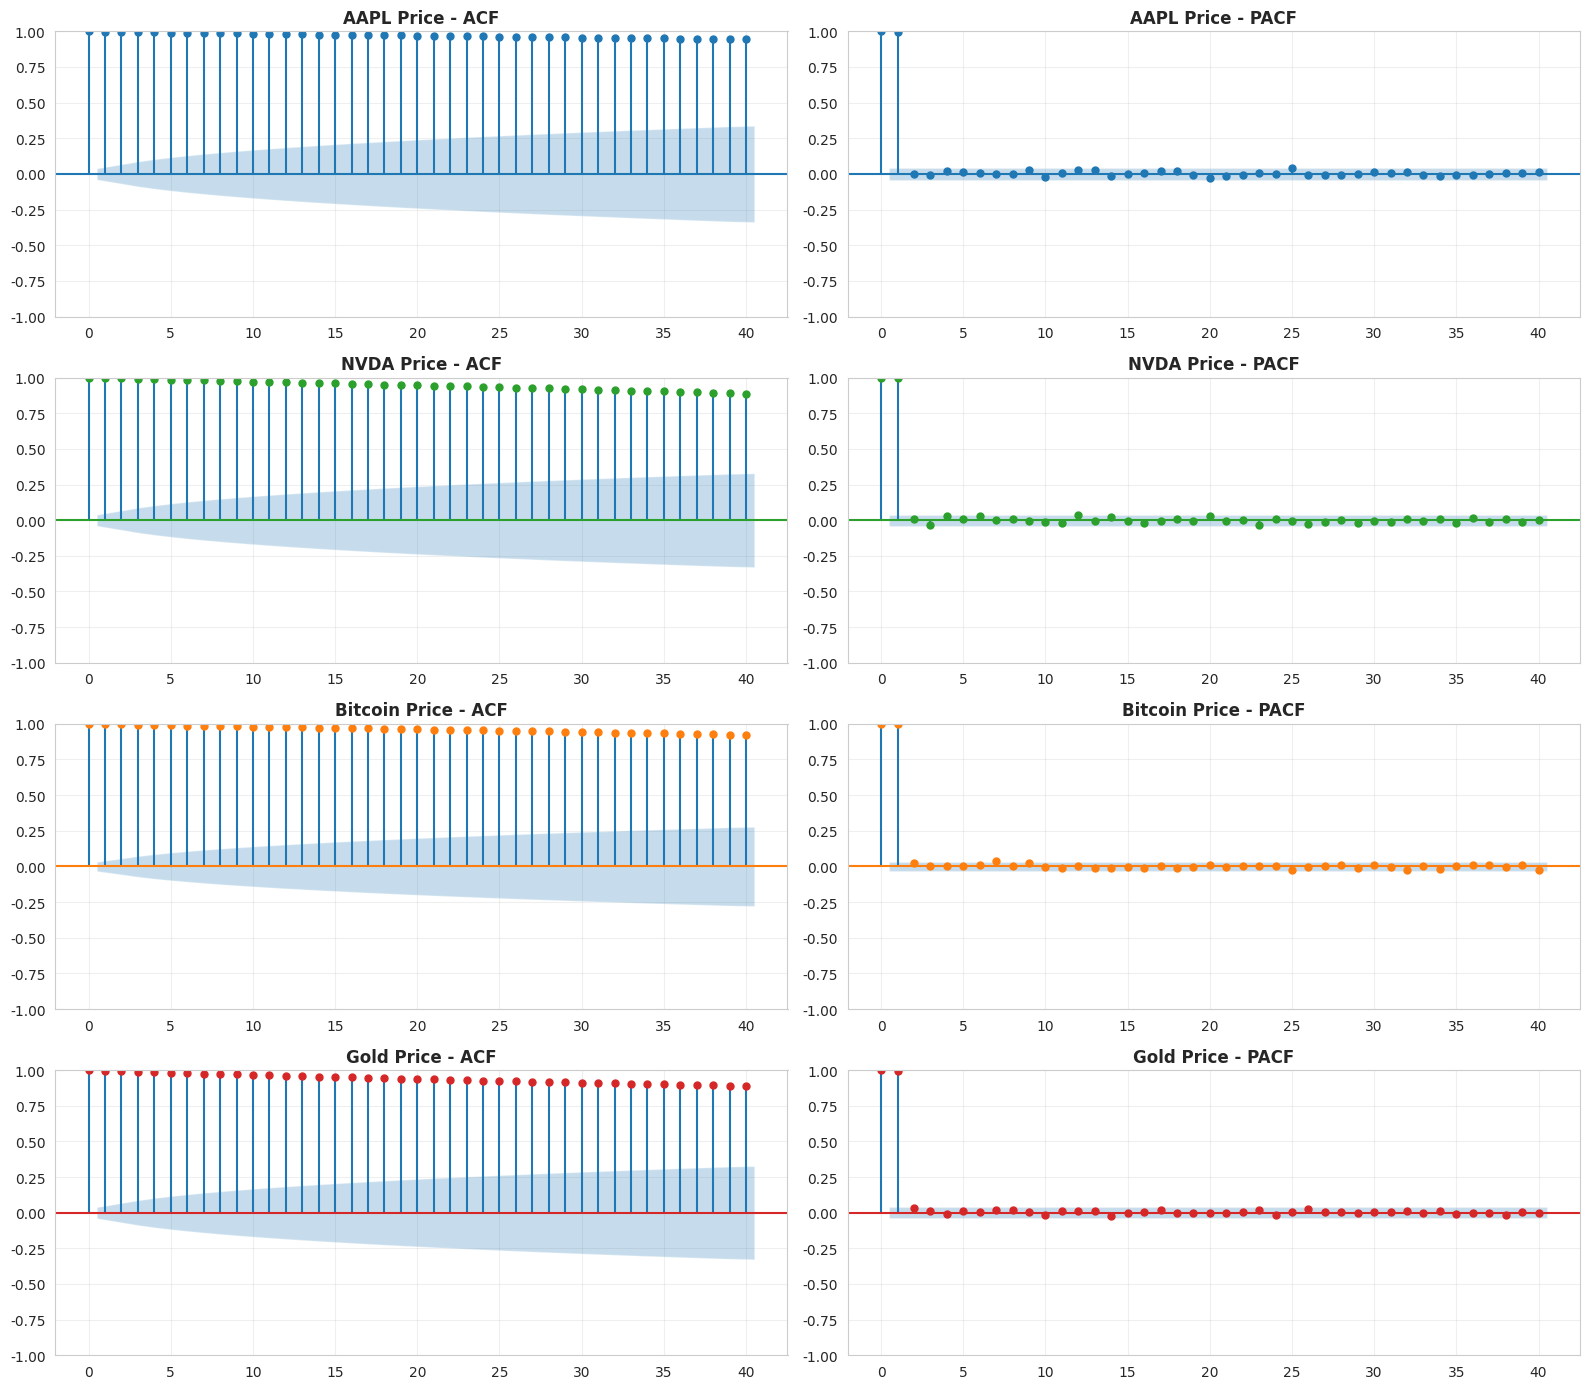

In [20]:
# 가격의 자기상관 분석
fig, axes = plt.subplots(4, 2, figsize=(16, 14))

for idx, (asset_name, df) in enumerate(data.items()):
    # ACF
    plot_acf(df['price'].dropna(), lags=40, ax=axes[idx, 0], color=colors[idx])
    axes[idx, 0].set_title(f'{asset_name} Price - ACF', fontsize=12, fontweight='bold')
    axes[idx, 0].grid(True, alpha=0.3)

    # PACF
    plot_pacf(df['price'].dropna(), lags=40, ax=axes[idx, 1],
              method='ywm', color=colors[idx])
    axes[idx, 1].set_title(f'{asset_name} Price - PACF', fontsize=12, fontweight='bold')
    axes[idx, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**High autocorrelation slowly diminishes → Non-stationary (Random Walk Property)**

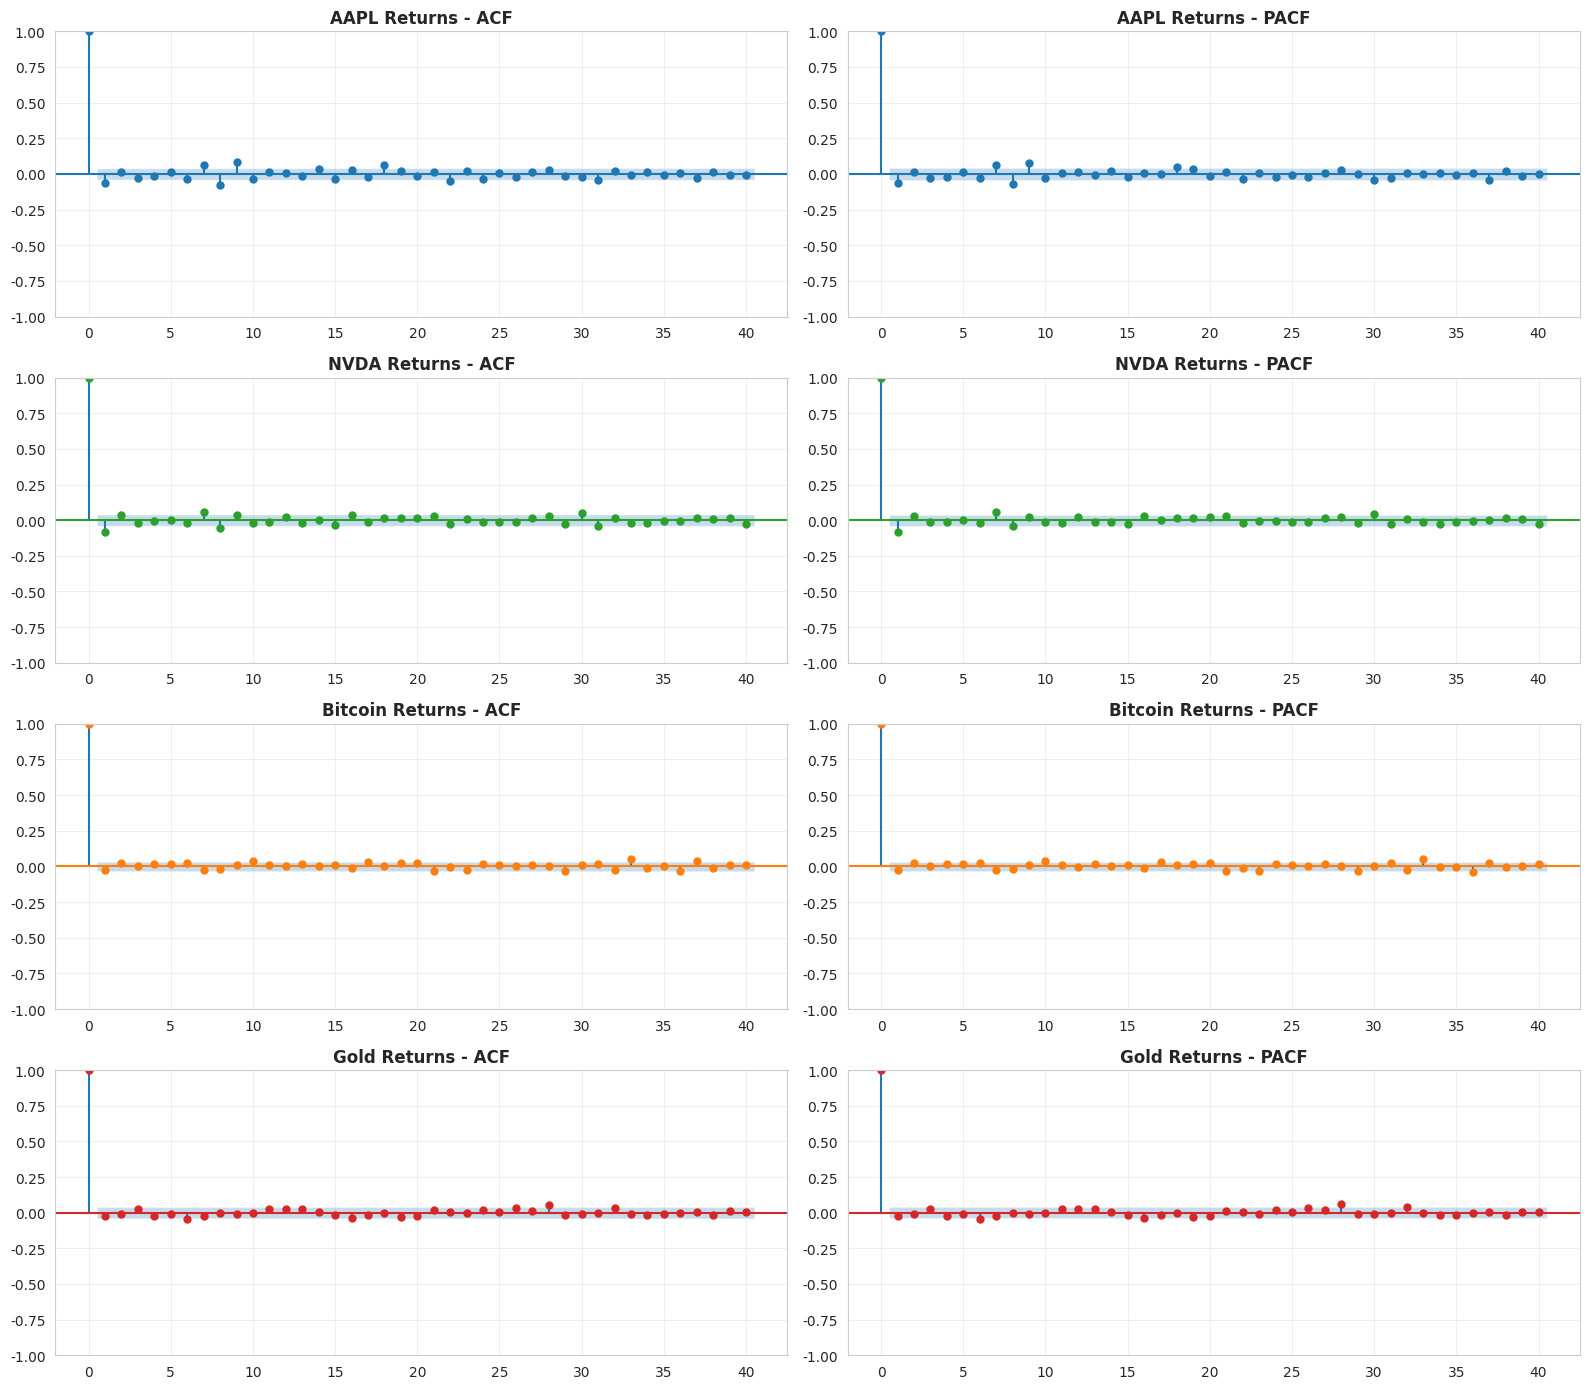

In [21]:
# 수익률의 자기상관 분석
fig, axes = plt.subplots(4, 2, figsize=(16, 14))

for idx, (asset_name, df) in enumerate(data.items()):
    # ACF
    plot_acf(df['returns'].dropna(), lags=40, ax=axes[idx, 0], color=colors[idx])
    axes[idx, 0].set_title(f'{asset_name} Returns - ACF', fontsize=12, fontweight='bold')
    axes[idx, 0].grid(True, alpha=0.3)

    # PACF
    plot_pacf(df['returns'].dropna(), lags=40, ax=axes[idx, 1],
              method='ywm', color=colors[idx])
    axes[idx, 1].set_title(f'{asset_name} Returns - PACF', fontsize=12, fontweight='bold')
    axes[idx, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**Mostly fall into the confidence interval → Stationary**

## 3.7. Unit Root Tests

### ADF Test

In [22]:
def adf_test(series, name):
    """
    ADF 검정 수행 및 결과 반환
    H0: 시계열에 단위근이 존재한다 (Non-stationary)
    H1: 시계열이 정상성을 가진다 (Stationary)
    """
    result = adfuller(series.dropna(), autolag='AIC')

    return {
        'Series': name,
        'ADF Statistic': result[0],
        'p-value': result[1],
        'Lags Used': result[2],
        'Observations': result[3],
        'Critical Value (1%)': result[4]['1%'],
        'Critical Value (5%)': result[4]['5%'],
        'Critical Value (10%)': result[4]['10%'],
        'Stationary': 'Yes ✅' if result[1] < 0.05 else 'No ❌'
    }


In [23]:
adf_results = []

# 가격 테스트
print("\n" + "-"*100)
print("PRICE SERIES")
print("-"*100)
for asset_name, df in data.items():
    result = adf_test(df['price'], f'{asset_name} Price')
    adf_results.append(result)
    print(f"\n{asset_name}:")
    print(f"  ADF Statistic: {result['ADF Statistic']:.6f}")
    print(f"  p-value: {result['p-value']:.6f}")
    print(f"  Result: {result['Stationary']}")



----------------------------------------------------------------------------------------------------
PRICE SERIES
----------------------------------------------------------------------------------------------------

AAPL:
  ADF Statistic: 0.244152
  p-value: 0.974632
  Result: No ❌

NVDA:
  ADF Statistic: 2.618807
  p-value: 0.999078
  Result: No ❌

Bitcoin:
  ADF Statistic: 0.731816
  p-value: 0.990452
  Result: No ❌

Gold:
  ADF Statistic: 3.507363
  p-value: 1.000000
  Result: No ❌


In [24]:
# 수익률 테스트
print("\n" + "-"*100)
print("RETURNS SERIES")
print("-"*100)
for asset_name, df in data.items():
    result = adf_test(df['returns'], f'{asset_name} Returns')
    adf_results.append(result)
    print(f"\n{asset_name}:")
    print(f"  ADF Statistic: {result['ADF Statistic']:.6f}")
    print(f"  p-value: {result['p-value']:.6f}")
    print(f"  Result: {result['Stationary']}")


----------------------------------------------------------------------------------------------------
RETURNS SERIES
----------------------------------------------------------------------------------------------------

AAPL:
  ADF Statistic: -16.297559
  p-value: 0.000000
  Result: Yes ✅

NVDA:
  ADF Statistic: -17.985698
  p-value: 0.000000
  Result: Yes ✅

Bitcoin:
  ADF Statistic: -42.233660
  p-value: 0.000000
  Result: Yes ✅

Gold:
  ADF Statistic: -51.154135
  p-value: 0.000000
  Result: Yes ✅


In [25]:
# 로그 수익률 테스트
print("\n" + "-"*100)
print("LOG RETURNS SERIES")
print("-"*100)
for asset_name, df in data.items():
    result = adf_test(df['log_returns'], f'{asset_name} Log Returns')
    adf_results.append(result)
    print(f"\n{asset_name}:")
    print(f"  ADF Statistic: {result['ADF Statistic']:.6f}")
    print(f"  p-value: {result['p-value']:.6f}")
    print(f"  Result: {result['Stationary']}")


----------------------------------------------------------------------------------------------------
LOG RETURNS SERIES
----------------------------------------------------------------------------------------------------

AAPL:
  ADF Statistic: -16.189505
  p-value: 0.000000
  Result: Yes ✅

NVDA:
  ADF Statistic: -17.918875
  p-value: 0.000000
  Result: Yes ✅

Bitcoin:
  ADF Statistic: -42.127534
  p-value: 0.000000
  Result: Yes ✅

Gold:
  ADF Statistic: -51.203430
  p-value: 0.000000
  Result: Yes ✅


In [26]:
# let's save the results
adf_df = pd.DataFrame(adf_results)

### KPSS Test

In [27]:
def kpss_test(series, name):
    """
    KPSS 검정 수행 및 결과 반환
    H0: 시계열이 정상성을 가진다 (Stationary)
    H1: 시계열에 단위근이 존재한다 (Non-stationary)
    """
    result = kpss(series.dropna(), regression='c', nlags='auto')

    return {
        'Series': name,
        'KPSS Statistic': result[0],
        'p-value': result[1],
        'Lags Used': result[2],
        'Critical Value (1%)': result[3]['1%'],
        'Critical Value (5%)': result[3]['5%'],
        'Critical Value (10%)': result[3]['10%'],
        'Stationary': 'Yes ✅' if result[1] >= 0.05 else 'No ❌'
    }

In [28]:
kpss_results = []

In [29]:
# 가격 테스트
print("\n" + "-"*100)
print("PRICE SERIES")
print("-"*100)
for asset_name, df in data.items():
    result = kpss_test(df['price'], f'{asset_name} Price')
    kpss_results.append(result)
    print(f"\n{asset_name}:")
    print(f"  KPSS Statistic: {result['KPSS Statistic']:.6f}")
    print(f"  p-value: {result['p-value']:.6f}")
    print(f"  Result: {result['Stationary']}")


----------------------------------------------------------------------------------------------------
PRICE SERIES
----------------------------------------------------------------------------------------------------

AAPL:
  KPSS Statistic: 7.911035
  p-value: 0.010000
  Result: No ❌

NVDA:
  KPSS Statistic: 5.275711
  p-value: 0.010000
  Result: No ❌

Bitcoin:
  KPSS Statistic: 6.585859
  p-value: 0.010000
  Result: No ❌

Gold:
  KPSS Statistic: 6.368990
  p-value: 0.010000
  Result: No ❌


/tmp/ipython-input-807102618.py:7: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c', nlags='auto')
/tmp/ipython-input-807102618.py:7: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c', nlags='auto')
/tmp/ipython-input-807102618.py:7: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c', nlags='auto')
/tmp/ipython-input-807102618.py:7: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  r

In [30]:
# 수익률 테스트
print("\n" + "-"*100)
print("RETURNS SERIES")
print("-"*100)
for asset_name, df in data.items():
    result = kpss_test(df['returns'], f'{asset_name} Returns')
    kpss_results.append(result)
    print(f"\n{asset_name}:")
    print(f"  KPSS Statistic: {result['KPSS Statistic']:.6f}")
    print(f"  p-value: {result['p-value']:.6f}")
    print(f"  Result: {result['Stationary']}")


----------------------------------------------------------------------------------------------------
RETURNS SERIES
----------------------------------------------------------------------------------------------------

AAPL:
  KPSS Statistic: 0.062712
  p-value: 0.100000
  Result: Yes ✅

NVDA:
  KPSS Statistic: 0.081098
  p-value: 0.100000
  Result: Yes ✅

Bitcoin:
  KPSS Statistic: 0.289657
  p-value: 0.100000
  Result: Yes ✅

Gold:
  KPSS Statistic: 0.361078
  p-value: 0.093932
  Result: Yes ✅


/tmp/ipython-input-807102618.py:7: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c', nlags='auto')
/tmp/ipython-input-807102618.py:7: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c', nlags='auto')
/tmp/ipython-input-807102618.py:7: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c', nlags='auto')


In [31]:
# 로그 수익률 테스트
print("\n" + "-"*100)
print("LOG RETURNS SERIES")
print("-"*100)
for asset_name, df in data.items():
    result = kpss_test(df['log_returns'], f'{asset_name} Log Returns')
    kpss_results.append(result)
    print(f"\n{asset_name}:")
    print(f"  KPSS Statistic: {result['KPSS Statistic']:.6f}")
    print(f"  p-value: {result['p-value']:.6f}")
    print(f"  Result: {result['Stationary']}")


----------------------------------------------------------------------------------------------------
LOG RETURNS SERIES
----------------------------------------------------------------------------------------------------

AAPL:
  KPSS Statistic: 0.053384
  p-value: 0.100000
  Result: Yes ✅

NVDA:
  KPSS Statistic: 0.085972
  p-value: 0.100000
  Result: Yes ✅

Bitcoin:
  KPSS Statistic: 0.214563
  p-value: 0.100000
  Result: Yes ✅

Gold:
  KPSS Statistic: 0.350183
  p-value: 0.098628
  Result: Yes ✅


/tmp/ipython-input-807102618.py:7: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c', nlags='auto')
/tmp/ipython-input-807102618.py:7: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c', nlags='auto')
/tmp/ipython-input-807102618.py:7: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c', nlags='auto')


In [32]:
kpss_df = pd.DataFrame(kpss_results)

### Comprehensive Test Results

In [33]:
# ADF와 KPSS 결과 통합
combined_results = pd.merge(
    adf_df[['Series', 'ADF Statistic', 'p-value', 'Stationary']],
    kpss_df[['Series', 'KPSS Statistic', 'p-value', 'Stationary']],
    on='Series',
    suffixes=('_ADF', '_KPSS')
)

In [34]:
def final_conclusion(row):
    if row['Stationary_ADF'] == 'Yes ✅' and row['Stationary_KPSS'] == 'Yes ✅':
        return 'Stationary ✅✅'
    elif row['Stationary_ADF'] == 'No ❌' and row['Stationary_KPSS'] == 'No ❌':
        return 'Non-stationary ❌❌'
    else:
        return 'Inconclusive ⚠️'

combined_results['Final Conclusion'] = combined_results.apply(final_conclusion, axis=1)

print("\n" + "="*120)
print("COMPREHENSIVE STATIONARITY TEST RESULTS")
print("="*120)
print(combined_results.to_string(index=False))
print("="*120)


COMPREHENSIVE STATIONARITY TEST RESULTS
             Series  ADF Statistic  p-value_ADF Stationary_ADF  KPSS Statistic  p-value_KPSS Stationary_KPSS  Final Conclusion
         AAPL Price       0.244152 9.746320e-01           No ❌        7.911035      0.010000            No ❌ Non-stationary ❌❌
         NVDA Price       2.618807 9.990784e-01           No ❌        5.275711      0.010000            No ❌ Non-stationary ❌❌
      Bitcoin Price       0.731816 9.904519e-01           No ❌        6.585859      0.010000            No ❌ Non-stationary ❌❌
         Gold Price       3.507363 1.000000e+00           No ❌        6.368990      0.010000            No ❌ Non-stationary ❌❌
       AAPL Returns     -16.297559 3.290945e-29          Yes ✅        0.062712      0.100000           Yes ✅     Stationary ✅✅
       NVDA Returns     -17.985698 2.765174e-30          Yes ✅        0.081098      0.100000           Yes ✅     Stationary ✅✅
    Bitcoin Returns     -42.233660 0.000000e+00          Yes ✅        